# 🧪 02 - Modeling and Basic Evaluation on Real Chicago Crime Data

## 🧭 Objective

This notebook loads the preprocessed real crime dataset from Chicago and performs a **baseline predictive modeling** using a simple **naive method** (per-cell mean). We then compute **standard spatial and temporal performance metrics** such as:

- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Predictive Accuracy Index (PAI)
- Predictive Efficiency Index (PEI)
- Adjusted PEI* (PEI-star)

These metrics serve as a baseline for evaluating more complex models and help contextualize the behavior of uncertainty-aware predictions.


# 📦 Step 1: Import Dependencies and Set Up Environment

We begin by importing core Python libraries (`pandas`, `numpy`, `matplotlib`, etc.) and custom modules from our `src/` directory, which provide:

- Naive and Poisson per-cell model implementations
- Temporal data splitting
- Grid reshaping utilities
- Evaluation functions for spatial-temporal metrics

Additionally, we configure the root path to ensure proper loading of external resources and modules.

In [ ]:
import os
import json
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))
sys.path.insert(0, project_root)

# Load modules 
from src.models.naive_cell import NaivePerCellModel
from src.utils.data_partition import temporal_split
from src.utils.transformations import ensure_full_grid
from src.evaluation.temporal_evaluation import (
                                                    evaluate_temporal_rmse_mae,
                                                    evaluate_temporal_spatial_metrics,
                                                    evaluate_spatial_metrics_over_coverages
                                                )

# 📁 Step 2: Load Configuration and Dataset

We load key parameters from the shared `config.json` file to ensure reproducibility and flexibility across experiments:

- **Hotspot definition method** (`by_crimes` or `by_cells`)
- **Evaluation percentage** (e.g., top 10% of crime)
- **Temporal partitioning** (train/calibration/test durations)

Next, we load the preprocessed crime data and beat-to-grid mapping. We restrict the dataset to selected crime types (all available in this example) and ensure all `(timestep, row, col)` combinations are present by filling missing grid points with zeros.

📦 Outputs:
- `df`: Complete spatio-temporal crime data
- `grid_size`: Tuple indicating spatial grid dimensions


In [11]:
# Load global config 
config_path = os.path.join("../../", "config.json")
with open(config_path, 'r') as f:
    config = json.load(f)

# Define hotspot method from config
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
hotspot_method = config["evaluation"].get("hotspot_definition", "by_cells")  # default

# Dynamically select hotspot definition method
if hotspot_method == "by_crimes":
    from src.utils.spatial_processing import define_hotspot_by_crimes as define_hotspot
elif hotspot_method == "by_cells":
    from src.utils.spatial_processing import define_hotspot_by_cells as define_hotspot
else:
    raise ValueError(f"Unknown hotspot_definition method: {hotspot_method}") 

# Partition data
partition_config = config["data_partition"]
days_per_month = 30
train_days = partition_config["train_months"] * days_per_month
calibration_days = partition_config["calibration_months"] * days_per_month
test_days = partition_config["test_months"] * days_per_month

# Paths
data_dir = "../../data/real_data/Chicago/"
df_path = os.path.join(data_dir, "chicago_crime_processed.csv")
map_path = os.path.join(data_dir, "beat_to_coord_map.json")

# Load
df = pd.read_csv(df_path)
with open(map_path) as f:
    beat_to_coord_map = json.load(f)

crime_types=df["crime_type"].unique()


df=df[df["crime_type"].isin(crime_types)].groupby(["timestep","row","col"]).sum().drop("crime_type",axis=1).reset_index()
df=ensure_full_grid(df, df.timestep.max(), tuple(df[["row","col"]].max()+1))
df.to_csv(os.path.join(data_dir,"df_used.csv"),index=False)
rows, cols = tuple(df[["row","col"]].max()+1)
grid_size = (rows, cols)
# Check structure
df.head()

,timestep,row,col,count
0,0,0,0,0
1,0,0,1,2
2,0,0,2,0
3,0,0,3,1
4,0,0,4,0


# 🚀 Step 3: Model Training and Evaluation

We train a **Naive Per-Cell Model**, which assumes the crime count in each cell is stationary and equal to its historical mean during training. This serves as a **baseline** for both prediction accuracy and uncertainty quantification.

### 📦 Workflow

1. **Partition** the dataset into train/calibration/test splits using the configuration file.
2. **Train** the model on the training set.
3. **Save** the fitted model for later use.
4. **Predict** crime counts on the test set.
5. **Evaluate** the results using two groups of metrics:
   - **Numeric (per timestep)**: RMSE and MAE.
   - **Spatial (per timestep)**: 
     - PAI (Predictive Accuracy Index)
     - PEI (Predictive Efficiency Index)
     - PEI* (Adjusted PEI)

### 📊 Coverage Sweep

We also assess spatial performance across different **crime coverage percentages** (1% to 50%), generating performance curves to visualize trade-offs.

📂 Model saved to: `../../results/models/real_data/Chicago/naive_cell_model.pkl`


In [13]:
df_train, df_calib, df_test = temporal_split(df, train_days, train_days + calibration_days, train_days + calibration_days + test_days)

# Features
features = ["timestep", "row", "col"]
target = "count"

X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

# Train cell-based models
naive_model = NaivePerCellModel()
naive_model.fit(X_train, y_train)


# Save models
path_dir="../../results/models/real_data/Chicago/"
os.makedirs(path_dir, exist_ok=True)
joblib.dump(naive_model, os.path.join(path_dir,"naive_cell_model.pkl"))

# Predict
naive_pred = naive_model.predict(X_test)

# Temporal numeric evaluation
print("\n🔹 Temporal numeric evaluation (per timestep):\n")
for name, pred in zip(["NaiveCell", "PoissonPerCell"], [naive_pred]):
    scores = evaluate_temporal_rmse_mae(X_test, y_test, pred)
    print(f"{name} - RMSE: {scores['rmse_mean']:.3f} ± {scores['rmse_std']:.3f} | MAE: {scores['mae_mean']:.3f} ± {scores['mae_std']:.3f}")

# Temporal spatial evaluation
print("\n🔹 Temporal spatial metrics (per timestep):\n")
for name, pred in zip(["NaiveCell", "PoissonPerCell"], [naive_pred]):
    spatial_scores = evaluate_temporal_spatial_metrics(X_test, y_test, pred, grid_size, hotspot_percentage)
    print(f"{name}:")
    print(f"  PAI:     {spatial_scores['pai_mean']:.3f} ± {spatial_scores['pai_std']:.3f}")
    print(f"  PEI:     {spatial_scores['pei_mean']:.3f} ± {spatial_scores['pei_std']:.3f}")
    print(f"  PEI*:    {spatial_scores['pei_star_mean']:.3f} ± {spatial_scores['pei_star_std']:.3f}\n")

# 🔄 Evaluate over multiple coverages
coverages = np.linspace(0.01, 0.5, 10)
curves = {}
for name, pred in zip(["NaiveCell", "PoissonPerCell"], [naive_pred]):
    curves[name] = evaluate_spatial_metrics_over_coverages(X_test, y_test, pred, grid_size, coverages)


🔹 Temporal numeric evaluation (per timestep):

NaiveCell - RMSE: 1.435 ± 0.149 | MAE: 1.052 ± 0.073

🔹 Temporal spatial metrics (per timestep):

NaiveCell:
  PAI:     2.077 ± 0.299
  PEI:     0.557 ± 0.086
  PEI*:    0.618 ± 0.081



# 📉 Step 4: Plot Spatial Metrics vs Coverage

We visualize how the spatial performance metrics evolve as we increase the percentage of predicted crime covered (i.e., **hotspot coverage**). These plots help assess the **efficiency and precision** of the predicted hotspots at various operational thresholds.

📊 Metrics plotted:
- **PAI**: Predictive Accuracy Index
- **PEI**: Predictive Efficiency Index
- **PEI\***: Adjusted PEI assuming equal-area comparisons

Each curve shows:
- **Mean metric value** across timesteps
- **Shaded region** representing ±1 standard deviation

These visualizations provide insight into model behavior under different resource allocation levels.


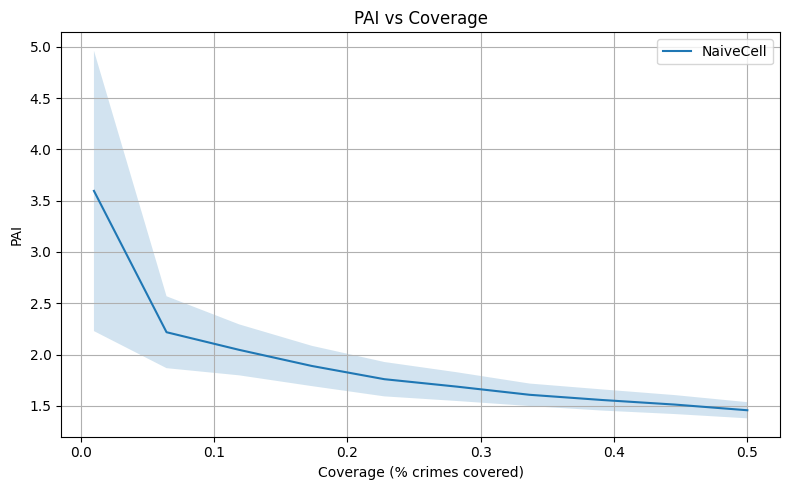

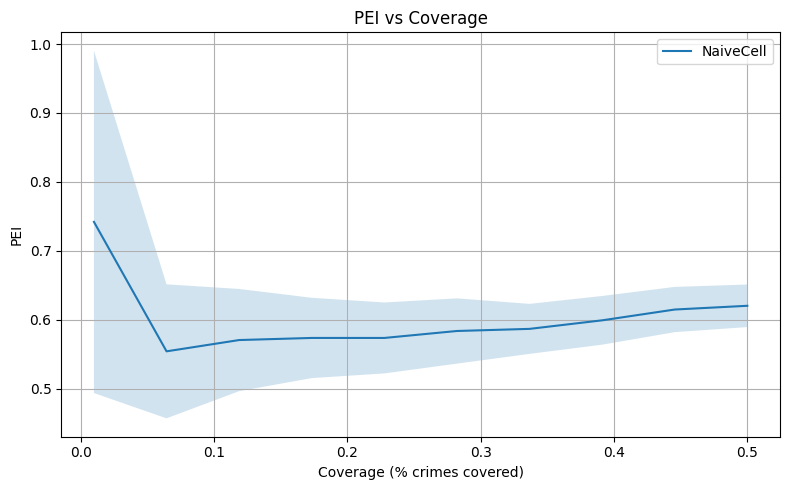

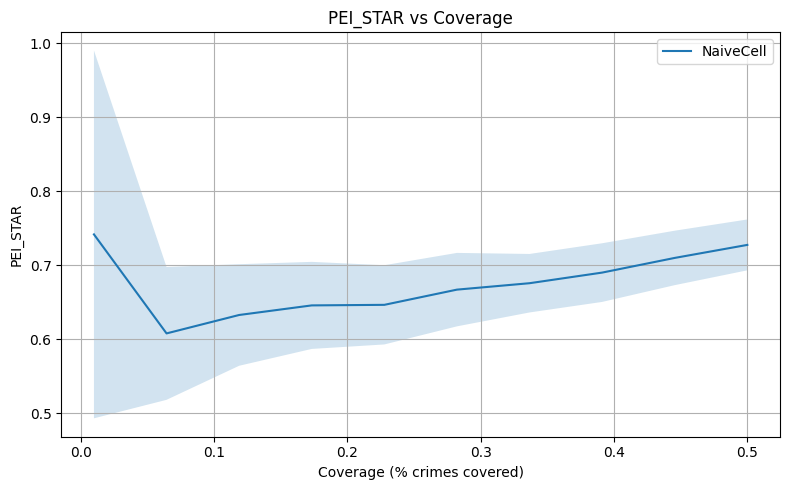

In [14]:
# 📈 Plot curves with seaborn
metrics = ["pai", "pei", "pei_star"]
for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model in curves:
        df = curves[model]
        mean_col = f"{metric}_mean"
        std_col = f"{metric}_std"
        
        sns.lineplot(x="coverage", y=mean_col, data=df, label=model)
        plt.fill_between(df["coverage"], df[mean_col] - df[std_col], df[mean_col] + df[std_col], alpha=0.2)

    plt.xlabel("Coverage (% crimes covered)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} vs Coverage")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()